In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import os
from PIL import Image

In [3]:
ckpt_dir = "/home/ccl/Code/svox2/opt/ckpt_auto/scannerf_light_short"
plot_dir = "/home/ccl/Downloads/plots"


def load_results(results_dir):
    c2ws = np.load(os.path.join(results_dir, "c2ws.npy"))
    psnr = np.load(os.path.join(results_dir, "psnr.npy"))
    ssim = np.load(os.path.join(results_dir, "ssim.npy"))
    lpips = np.load(os.path.join(results_dir, "lpips.npy"))
    return c2ws, psnr, ssim, lpips
    
splits = ["all_100", "all"]
# splits = ["all_100", "all_250", "all_500", "all"]
scenes = ["airplane1", "brontosaurus", "lego"]
# scenes = ["airplane1", "airplane2", "brontosaurus", "bulldozer1", "bulldozer2", "cheetah", "dump_truck1", "dump_truck2", "elephant", "excavator", "forklift", "giraffe", "helicopter1", "helicopter2", "lego", "lion", "plant1", "plant2", "plant3", "plant4", "plant5", "plant6", "plant7", "plant8", "plant9", "roadroller", "shark", "spinosaurus", "stegosaurus", "tiger", "tractor", "trex", "triceratops", "truck", "zebra"]
c2ws_test = {}
c2ws_train = {}
psnr_test = {}
psnr_train = {}


for split in splits:
    c2ws_test[split] = {}
    c2ws_train[split] = {}
    psnr_test[split] = {}
    psnr_train[split] = {}
    for scene in scenes:
        test_results_dir = os.path.join(ckpt_dir, split, scene, "test_renders")
        train_results_dir = os.path.join(ckpt_dir, split, scene, "train_renders")

        c2ws_test_i, psnr_test_i, ssim_test_i, lpips_test_i = load_results(test_results_dir)
        c2ws_train_i, psnr_train_i, ssim_train_i, lpips_train_i = load_results(train_results_dir)
        
        c2ws_test[split][scene] = c2ws_test_i
        c2ws_train[split][scene] = c2ws_train_i
        psnr_test[split][scene] = psnr_test_i
        psnr_train[split][scene] = psnr_train_i

c2ws = next(iter(next(iter(c2ws_test.values())).values()))
center_pt = np.zeros(3)
directions = (c2ws[:,:3,3] - center_pt)
directions = directions / np.linalg.norm(directions, keepdims=True, axis=1)

angles_equator = np.arctan2(directions[:,0], directions[:,2])
angles_vert_x = np.arctan2(-directions[:,1], directions[:,0])
angles_vert_z = np.arctan2(-directions[:,1], directions[:,2])

# best_psnr = np.max(psnrs, axis=0)
# best_psnr_idx = np.argmax(psnrs, axis=0)

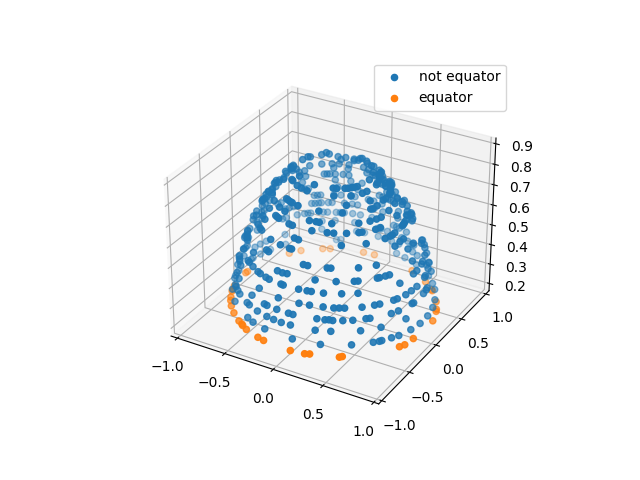

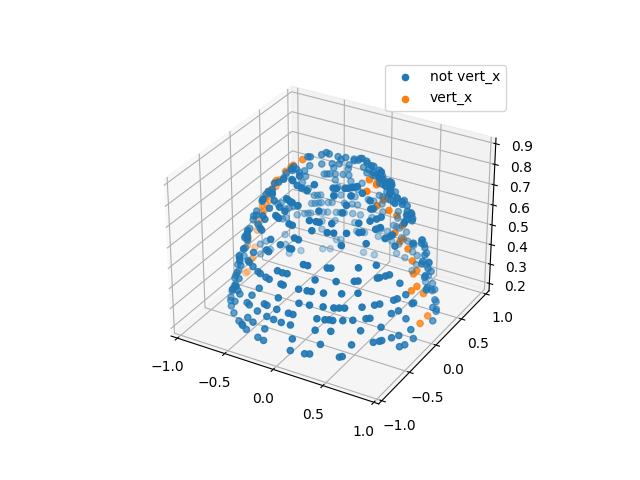

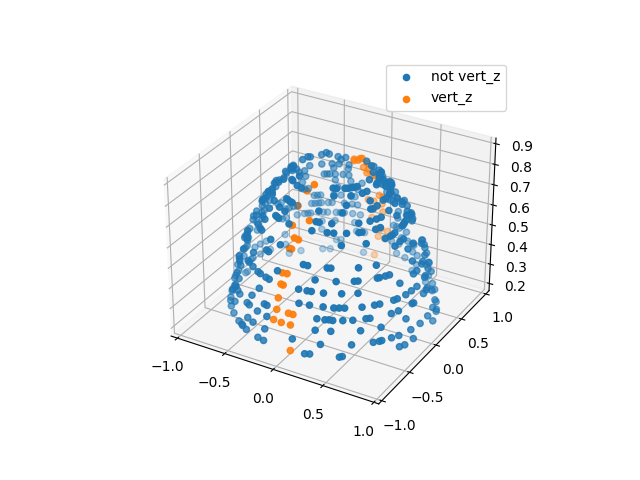

In [4]:
def xyz(c2ws):
    return c2ws[:,0,3], c2ws[:,2,3], -c2ws[:,1,3]

def plot_filter(condition, labels, filename, angles):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    inlier = np.where(condition)
    outlier = np.where(np.logical_not(condition))
    ax.scatter(*xyz(c2ws[outlier]), label=labels[1])
    ax.scatter(*xyz(c2ws[inlier]), label=labels[0])
    ax.legend()
    fig.savefig(os.path.join(plot_dir, filename))
    
    return inlier[0]

everything = range(c2ws.shape[0])
equator = plot_filter(c2ws[:,1,3] > -0.25, ["equator", "not equator"], "equator_selection.jpeg", angles_equator)
vert_x = plot_filter(np.abs(c2ws[:,2,3]) < 0.1, ["vert_x", "not vert_x"], "vert_x_selection.jpeg", angles_vert_x)
vert_z = plot_filter(np.abs(c2ws[:,0,3]) < 0.1, ["vert_z", "not vert_z"], "vert_z_selection.jpeg", angles_vert_z)


In [ ]:
%matplotlib inline

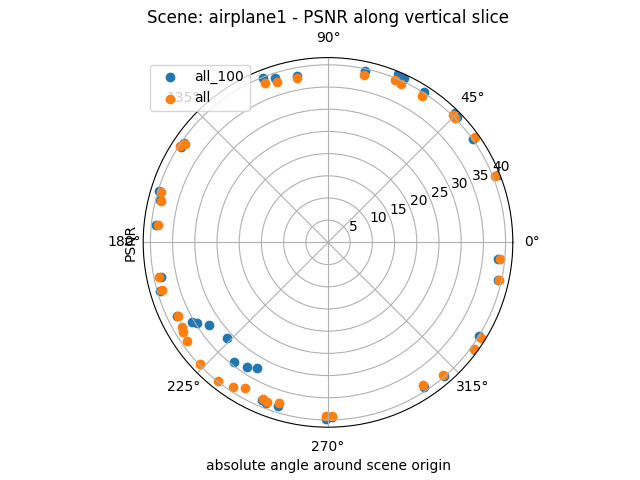

In [5]:
def plot_quality(scene, theta, quality, img_ids, filename):
    fig = plt.figure()
    ax = fig.add_subplot(projection='polar')
    plt.ylabel("PSNR")
    plt.xlabel("absolute angle around scene origin")
    plt.title(f"Scene: {scene} - PSNR along vertical slice")
    for split in splits:
        r = quality[split][scene]
        ax.scatter(theta[img_ids], r[img_ids], label=f"{split}")

    ax.legend()
    fig.savefig(os.path.join(plot_dir, filename))
    return fig

fig = plot_quality("airplane1", angles_equator, psnr_test, equator, f"{scene}_psnr_equator.jpeg")
# plt.close(fig)
# fig = plot_quality(scene, angles_vert_x, psnr_test, vert_x, f"{scene}_psnr_vert_x.jpeg")
# plt.close(fig)
# fig = plot_quality(scene, angles_vert_z, psnr_test, vert_z, f"{scene}_psnr_vert_z.jpeg")
# plt.close(fig)



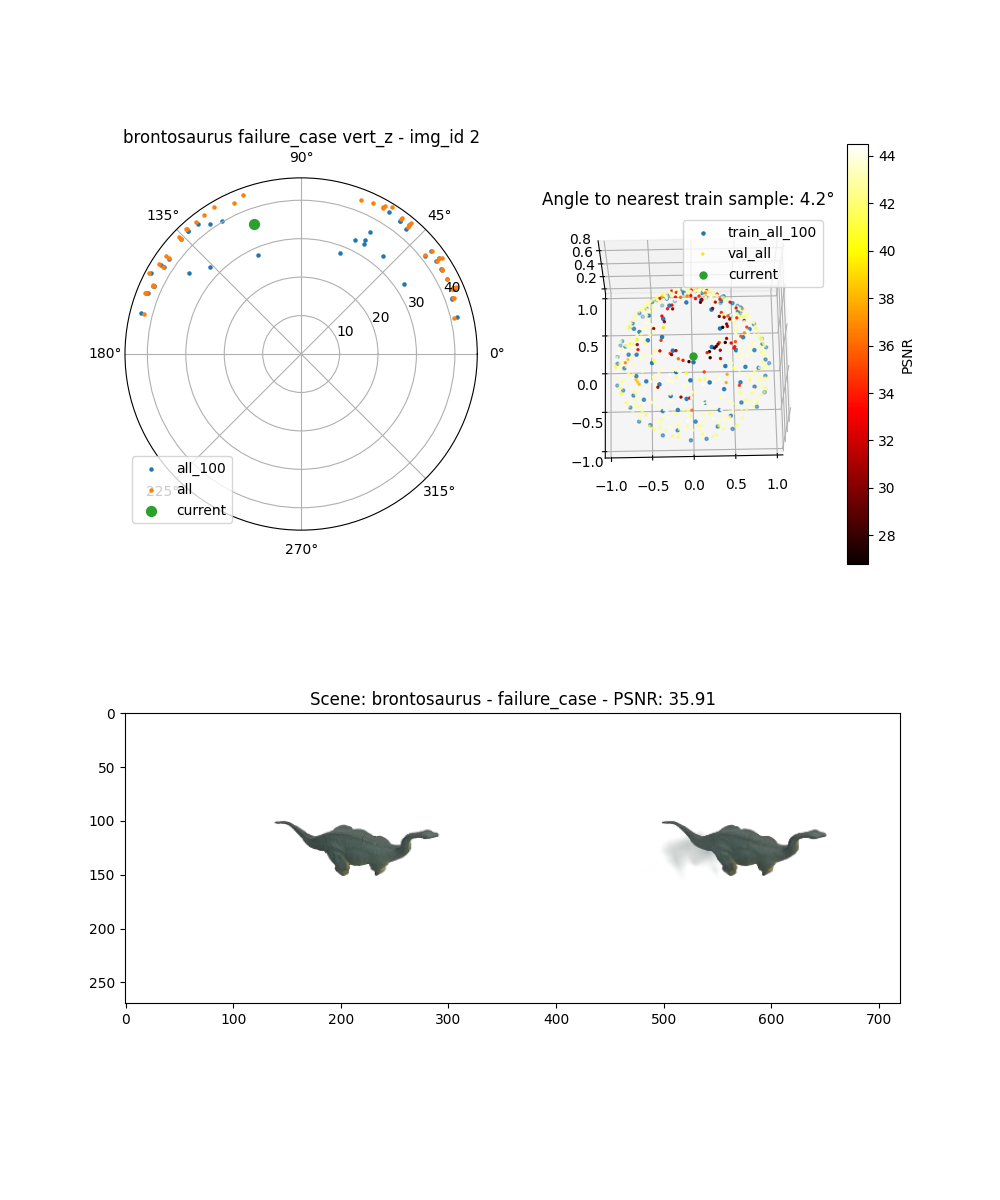

In [10]:
def view_angles_from_direction(direction):
    shadow_len = np.sqrt(direction[0]*direction[0] + direction[2]*direction[2])
    elev = np.arctan2(-direction[1], shadow_len)
    azim = np.arctan2(direction[2], direction[0])
    return elev, azim

def vis_sample(scene, img_id, desc, img_ids, angles, selected_split, filter_name):
    directions_train = (c2ws_train[selected_split][scene][:,:3,3] - center_pt)
    directions_train = directions_train / np.linalg.norm(directions_train, keepdims=True, axis=1)
    cos_dist = np.matmul(directions, directions_train.transpose())
    closest_train_index = np.argmax(cos_dist, axis=1)
    cos_dist = np.max(cos_dist, axis=1)
    rel_angles = np.arccos(cos_dist) * 180 / np.pi
    
    fig = plt.figure(figsize=(10,12))
    gs = GridSpec(2,2, figure=fig)
    ax1 = fig.add_subplot(gs[0,0], projection='polar')
    ax2 = fig.add_subplot(gs[1,:])
    ax3 = fig.add_subplot(gs[0,1], projection='3d')
    theta = angles[img_ids]
    
    psnr = psnr_test[selected_split][scene][img_id]
    
    ax1.title.set_text(f"{scene} {desc} {filter_name} - img_id {img_id}")
    for j, split in enumerate(splits):
        r = psnr_test[split][scene]
        ax1.scatter(theta, r[img_ids], s=5, label=split)
    ax1.scatter(angles[img_id], psnr, s=50, label=f"current")
    ax1.legend()
    
    
    img_path = os.path.join(ckpt_dir, selected_split, scene, "test_renders", f'{img_id:04d}.png')
    img = np.asarray(Image.open(img_path))
    ax2.title.set_text(f"Scene: {scene} - {desc} - PSNR: {psnr:.2f}")
    ax2.imshow(img)

    
    ax3.scatter(*xyz(c2ws_train[selected_split][scene]), s=5, label=f"train_{selected_split}")
    ax3.title.set_text(f"Angle to nearest train sample: {rel_angles[img_id]:.1f}°")
    plot = ax3.scatter(*xyz(c2ws), c=psnr_test[selected_split][scene], cmap='hot', s=2, label=f"val_all")
    ax3.scatter(*xyz(c2ws[img_id:img_id+1]), c="#2ca02c", s=25, label=f"current")
    ax3.legend()
    fig.colorbar(plot).set_label('PSNR')
    elev, azim = view_angles_from_direction(directions[img_id])
    ax3.view_init(elev=elev*180/np.pi, azim=azim*180/np.pi)
    
    fig.savefig(os.path.join(plot_dir, f"{scene}_{desc}_{psnr:.01f}_{img_id}.png"))
    
vis_sample("brontosaurus", vert_z[0], "failure_case", vert_z, angles_vert_z, "all_100", "vert_z")

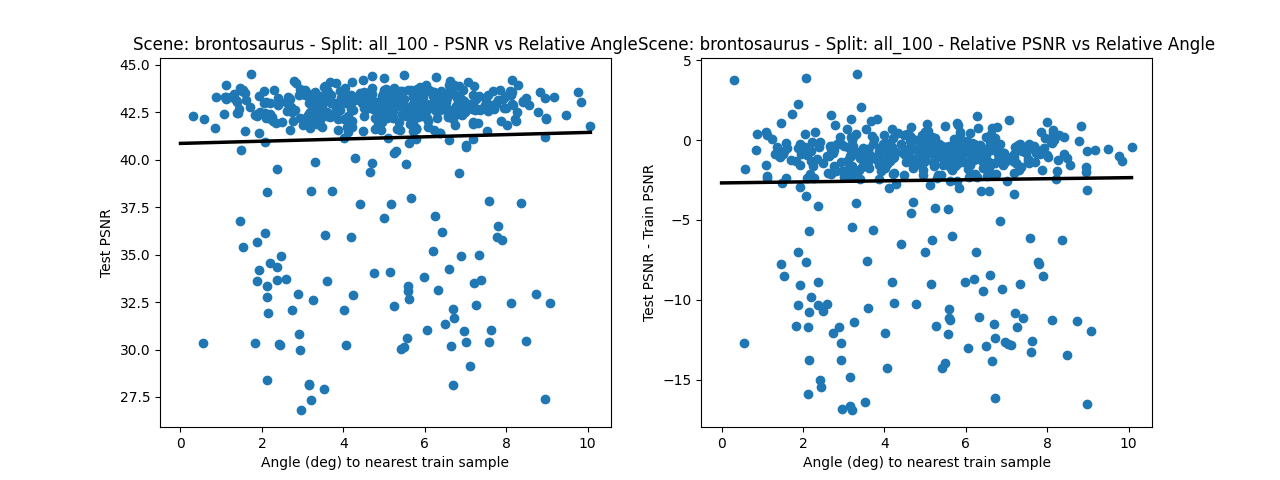

In [8]:
def vis_relative_angles(scene, img_ids, selected_split, filter_name):
    directions_train = (c2ws_train[selected_split][scene][:,:3,3] - center_pt)
    directions_train = directions_train / np.linalg.norm(directions_train, keepdims=True, axis=1)
    cos_dist = np.matmul(directions, directions_train.transpose())
    closest_train_index = np.argmax(cos_dist, axis=1)
    cos_dist = np.max(cos_dist, axis=1)
    rel_angles = np.arccos(cos_dist) * 180 / np.pi
    
    x = rel_angles[img_ids]
    y = psnr_test[selected_split][scene][img_ids]
    
    fig = plt.figure(figsize=(12.8, 4.8))
    gs = GridSpec(1,2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0,0])
    ax1.set_title(f"Scene: {scene} - Split: {selected_split} - PSNR vs Relative Angle")
    ax1.set_xlabel("Angle (deg) to nearest train sample")
    ax1.set_ylabel("Test PSNR")
    ax1.scatter(x, y)
    b, a = np.polyfit(x, y, deg=1)
    xseq = np.linspace(0, np.max(x), num=100)
    ax1.plot(xseq, a + b * xseq, color="k", lw=2.5)
    
    y = psnr_test[selected_split][scene][img_ids] - psnr_train[selected_split][scene][closest_train_index[img_ids]]
    ax2 = fig.add_subplot(gs[0,1])
    ax2.set_title(f"Scene: {scene} - Split: {selected_split} - Relative PSNR vs Relative Angle")
    ax2.set_xlabel("Angle (deg) to nearest train sample")
    ax2.set_ylabel("Test PSNR - Train PSNR")
    ax2.scatter(x, y)
    b, a = np.polyfit(x, y, deg=1)
    xseq = np.linspace(0, np.max(x), num=100)
    ax2.plot(xseq, a + b * xseq, color="k", lw=2.5)
    
    fig.savefig(os.path.join(plot_dir, f"{scene}_relative_angles_{selected_split}_{filter_name}.png"))

vis_relative_angles("brontosaurus", everything, "all_100", "everything")

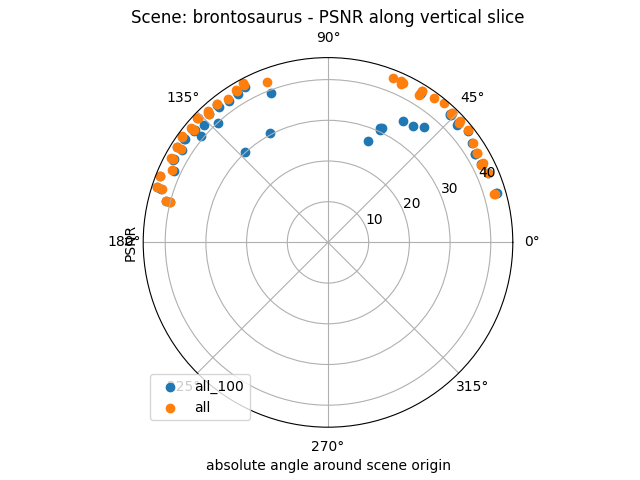

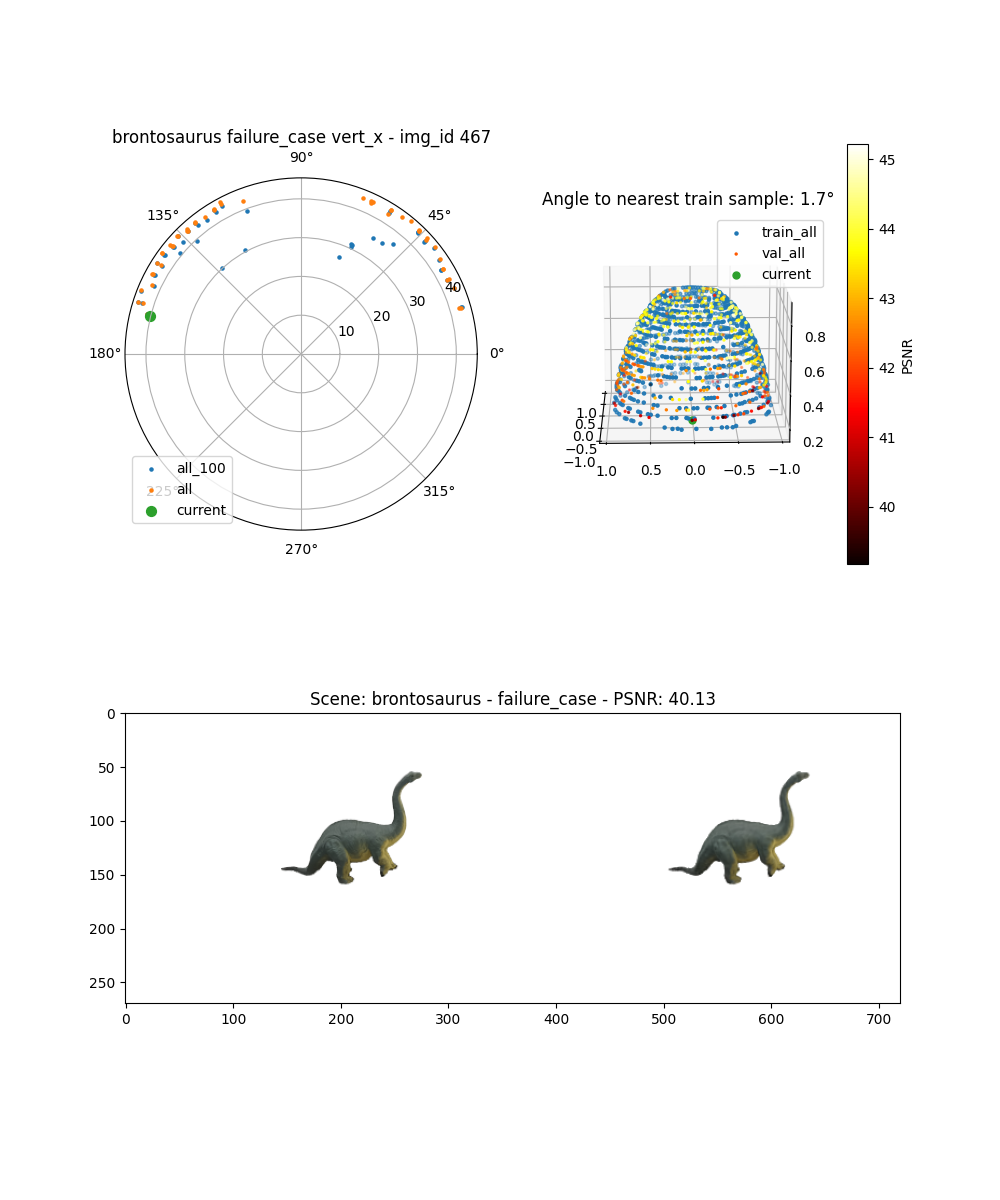

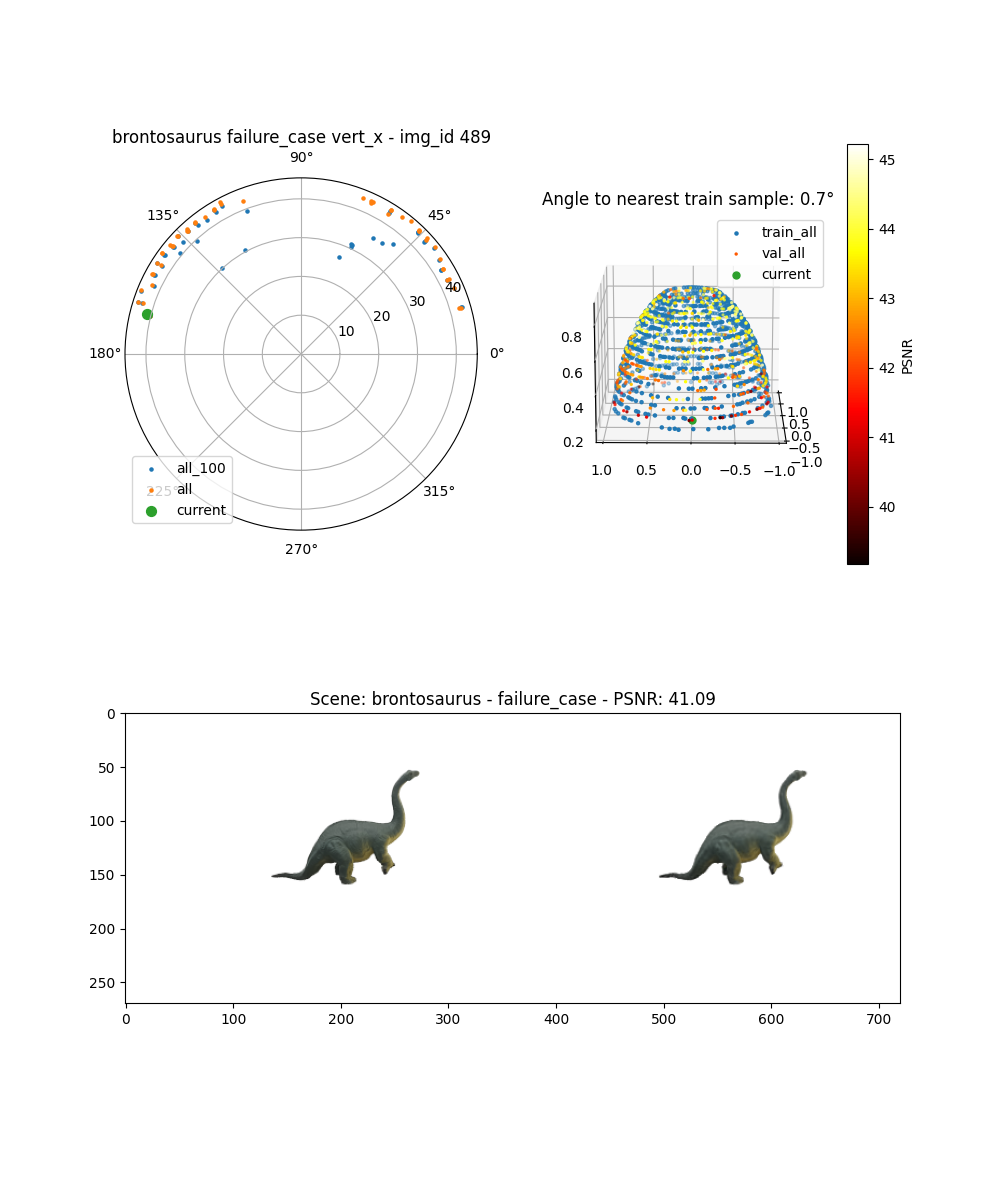

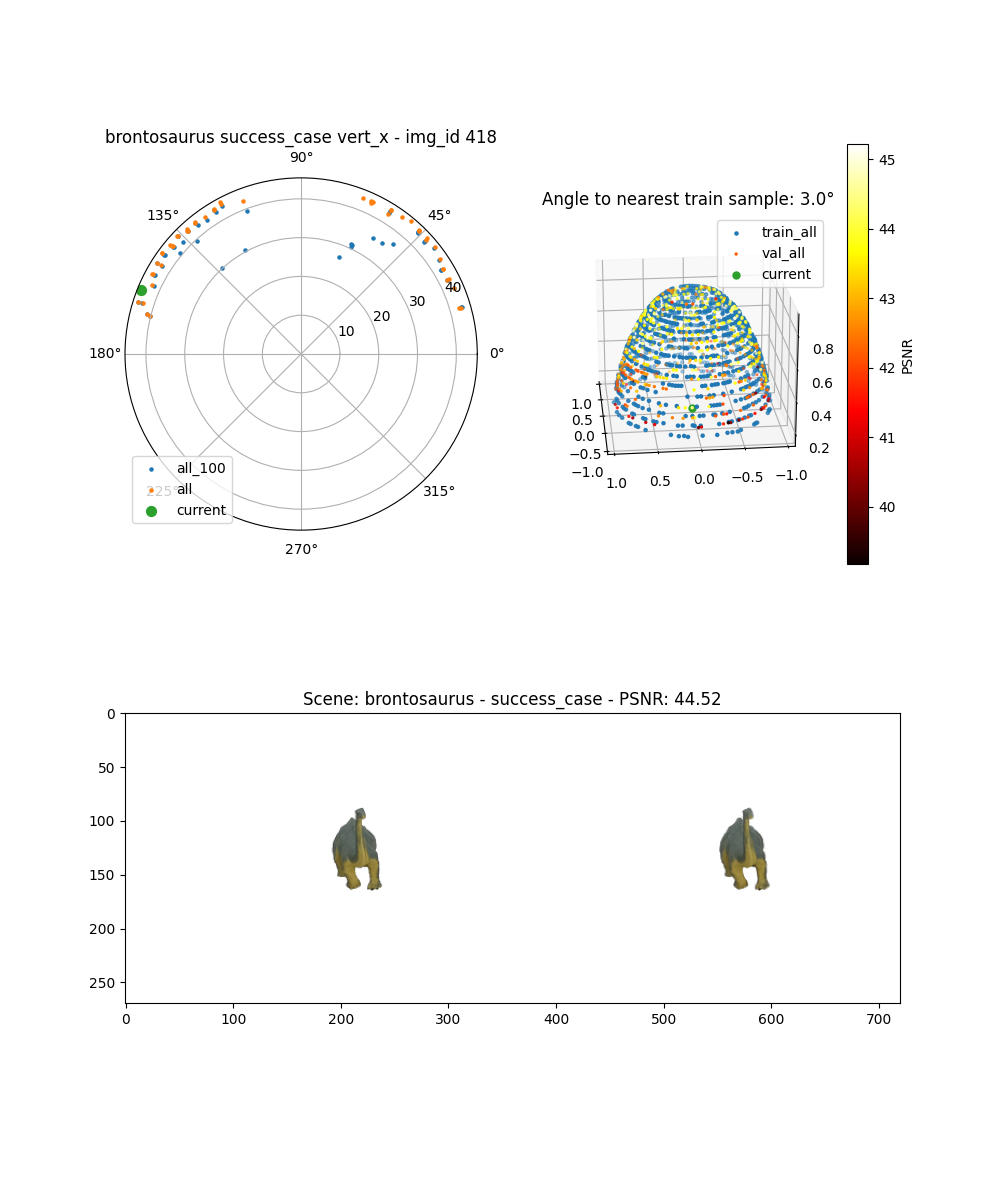

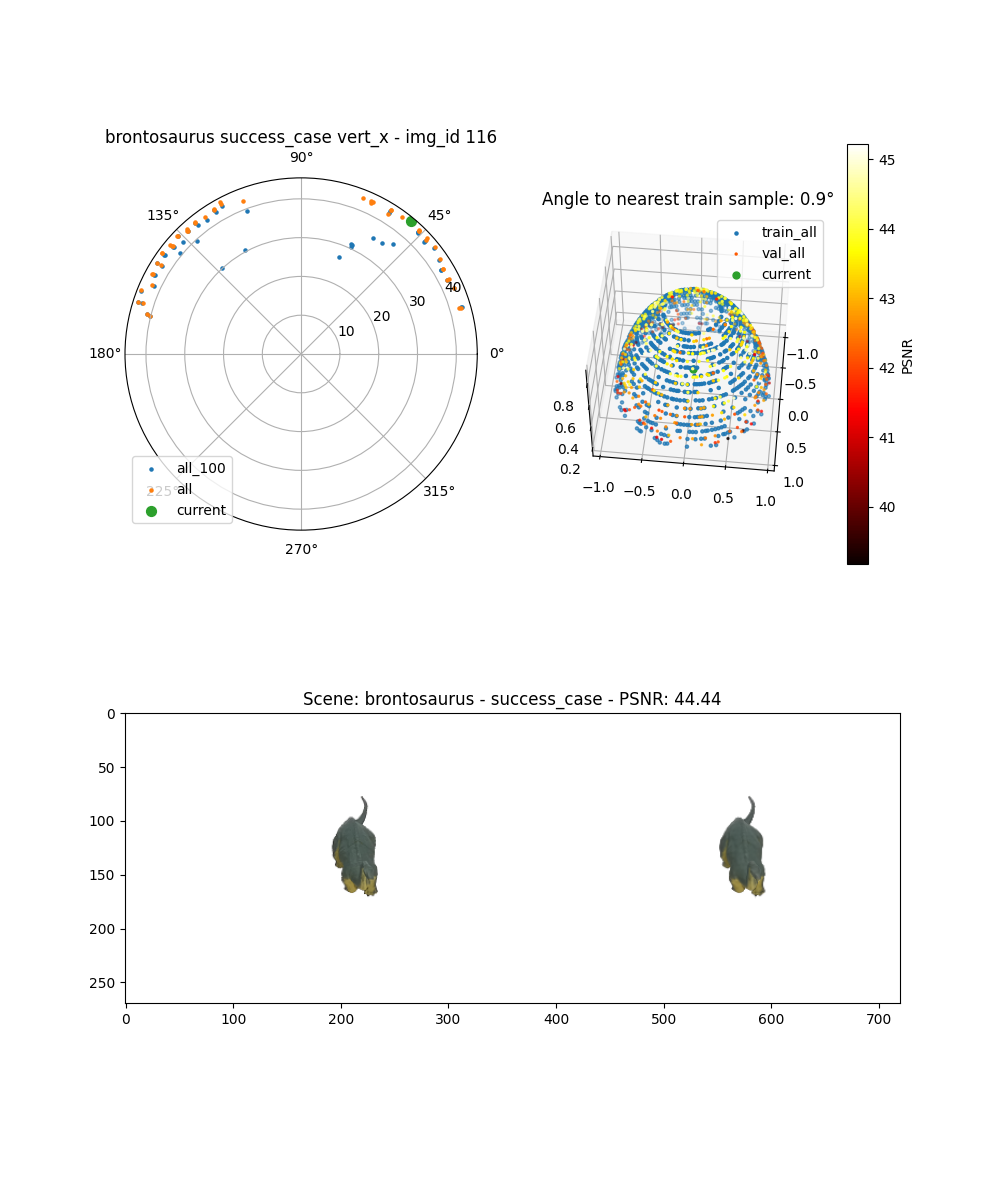

In [9]:
sample_num = 2
scene = "brontosaurus"
selected_split = "all"

# filter_name = "everything"
# img_ids = everything
# angles = angles_equator

# filter_name = "equator"
# img_ids = equator
# angles = angles_equator

filter_name = "vert_x"
img_ids = vert_x
angles = angles_vert_x

# filter_name = "vert_z"
# img_ids = vert_z
# angles = angles_vert_z

fail_idx = np.argsort(psnr_test[selected_split][scene][img_ids])[:sample_num]
success_idx = np.argsort(psnr_test[selected_split][scene][img_ids])[-sample_num:][::-1]
print()
fig = plot_quality(scene, angles, psnr_test, img_ids, f"{scene}_psnr_{filter_name}.jpeg")
for img_id in list(img_ids[fail_idx]):
    vis_sample(scene, img_id, "failure_case", img_ids, angles, selected_split, filter_name)
for img_id in list(img_ids[success_idx]):
    vis_sample(scene, img_id, "success_case", img_ids, angles, selected_split, filter_name)

In [ ]:

fig = plt.figure(figsize=(10,8))
plt.title("locations of different training/validation samples")
ax = fig.add_subplot(projection='3d')

ax.scatter(*xyz(c2ws), s=5, label="val_all")
for split in splits:
    # plt.title(f"train locations {split}")
    ax.scatter(*xyz(c2ws_train[split][scene]), s=5, label=f"train_{split}")

ax.legend()
fig.savefig(f"/home/ccl/Downloads/plots/{scene}_sample_locations.jpeg")